In [1]:
import os
import sys
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.ticker as mtick
import matplotlib.patches as patches
import matplotlib.font_manager as fm
import time
from typing import Dict, Tuple
from concurrent.futures import ThreadPoolExecutor
import requests
import json
import sys
import argparse
import time

sys.path.append(os.path.abspath('.'))
from src.data_parse import DataParser

LOGDIR = 'logs'
benchmark_log = "exp2_dv5_load_balancing_disabled"
exp_logs = ["exp2_dv5_load_balancing_enabled", 
            "exp2_dv5_prune_depth2_FIFO", 
            "exp2_dv5_prune_depth1_FIFO", 
            "exp2_dv5_prune_depth1_storage-footprint-aware"]

# some workers are not representative of the overall performance, so we exclude them
outlier_workers = [[],
                   [],
                   ["10.32.93.31:56860","10.32.88.127:34838","10.32.88.127:57232"],
                   [],
                   []]

logs = [benchmark_log] + list(exp_logs)
logs = [os.path.join(LOGDIR, log) for log in logs]

data_parsers = []
for log in tqdm.tqdm(logs, desc="Parsing logs"):
    data_parser = DataParser(log)
    data_parser.restore_from_checkpoint()
    data_parsers.append(data_parser)



Parsing logs:   0%|          | 0/5 [00:00<?, ?it/s]

Restoring workers.pkl took 4.1049 seconds
Restoring files.pkl took 12.7716 seconds


Parsing logs:  20%|██        | 1/5 [00:21<01:25, 21.39s/it]

Restoring tasks.pkl took 4.4406 seconds
Restoring manager.pkl took 0.0018 seconds
Restoring subgraphs.pkl took 0.0721 seconds
Restoring workers.pkl took 5.0535 seconds
Restoring files.pkl took 15.3503 seconds


Parsing logs:  40%|████      | 2/5 [00:49<01:15, 25.13s/it]

Restoring tasks.pkl took 7.2638 seconds
Restoring manager.pkl took 0.0018 seconds
Restoring subgraphs.pkl took 0.0717 seconds
Restoring workers.pkl took 2.1317 seconds
Restoring files.pkl took 17.2479 seconds


Parsing logs:  60%|██████    | 3/5 [01:19<00:54, 27.37s/it]

Restoring tasks.pkl took 10.5674 seconds
Restoring manager.pkl took 0.0021 seconds
Restoring subgraphs.pkl took 0.0835 seconds
Restoring workers.pkl took 2.3425 seconds
Restoring files.pkl took 13.7514 seconds


Parsing logs:  80%|████████  | 4/5 [01:48<00:28, 28.27s/it]

Restoring tasks.pkl took 13.4804 seconds
Restoring manager.pkl took 0.002 seconds
Restoring subgraphs.pkl took 0.0821 seconds
Restoring workers.pkl took 2.5979 seconds
Restoring files.pkl took 17.9008 seconds


Parsing logs: 100%|██████████| 5/5 [02:12<00:00, 26.55s/it]

Restoring tasks.pkl took 3.3126 seconds
Restoring manager.pkl took 0.0026 seconds
Restoring subgraphs.pkl took 0.084 seconds


In [2]:
def test_api(base_url, runtime_template, api_config):
    try:
        response = requests.get(
            f"{base_url}/api/change-runtime-template",
            params={"runtime_template": runtime_template}
        )
        response.raise_for_status()
        result = response.json()
        if not result.get("success", False):
            print(f"[ERROR] Failed to change runtime template: {runtime_template}")
            return None

        api_name = api_config["name"]

        if "variants" in api_config:
            results = []
            for variant in api_config["variants"]:
                try:
                    response = requests.get(f"{base_url}/api/{api_name}", params=variant)
                    response.raise_for_status()
                    results.append(response.json())
                except Exception as e:
                    print(f"[ERROR] Failed variant request {variant}: {e}")
                    return None
            return results if results else None

        params = api_config.get("params", None)
        response = requests.get(f"{base_url}/api/{api_name}", params=params)
        response.raise_for_status()
        return response.json()

    except Exception as e:
        print(f"[ERROR] Exception in test_api: {e}")
        return None

base_url = f"http://localhost:9122"
storage_consumption_api = {"name": "storage-consumption", "params": {
            "show_percentage": "false",
            "x_unit": "completed-tasks"
        }}

def get_one_log_storage_consumption(log):
    return test_api(base_url, log, storage_consumption_api)

def get_all_logs_storage_consumption(logs):
    return [get_one_log_storage_consumption(log) for log in logs]

def clean_storage_consumption_data(raw_data):
    if not isinstance(raw_data, dict):
        return {}

    clean_data = {}
    clean_data['file_size_unit'] = raw_data.get('file_size_unit', 'MB')
    clean_data['xMin'] = float(raw_data.get('xMin', 0))
    clean_data['xMax'] = float(raw_data.get('xMax', 0))
    clean_data['yMin'] = float(raw_data.get('yMin', 0))
    clean_data['yMax'] = float(raw_data.get('yMax', 1))
    clean_data['tickFontSize'] = int(raw_data.get('tickFontSize', 10))
    clean_data['xUnit'] = raw_data.get('xUnit', 'time')

    clean_data['xTickValues'] = [float(x) for x in raw_data.get('xTickValues', []) if x is not None]
    clean_data['yTickValues'] = [float(y) for y in raw_data.get('yTickValues', []) if y is not None]
    clean_data['worker_resources'] = raw_data.get('worker_resources', {})

    clean_data['worker_storage_consumption'] = {}
    for worker_id, points in raw_data.get('worker_storage_consumption', {}).items():
        valid_points = []
        for p in points:
            if isinstance(p, (list, tuple)) and len(p) == 2:
                try:
                    t = float(p[0])
                    v = float(p[1])
                    valid_points.append([t, v])
                except (ValueError, TypeError):
                    continue
        if valid_points:
            clean_data['worker_storage_consumption'][worker_id] = valid_points

    return clean_data


In [3]:
storage_consumption_raw_data = get_all_logs_storage_consumption(logs)

In [4]:
storage_consumption_filtered_data = [clean_storage_consumption_data(data) for data in storage_consumption_raw_data]

In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from matplotlib.ticker import FuncFormatter
from matplotlib.gridspec import GridSpec

def save_storage_consumption_plot(data, output_path="storage_consumption.pdf", exclude_workers=None, yMax=None, title=None):
    exclude_workers = set(exclude_workers or [])

    fig = plt.figure(figsize=(7, 5))
    gs = GridSpec(1, 1, figure=fig, left=0.2, right=0.82, top=0.72, bottom=0.2)
    ax = fig.add_subplot(gs[0])

    x_unit = data['xUnit']
    y_unit = data['file_size_unit']
    x_min, x_max = data['xMin'], data['xMax']
    y_min = data['yMin']
    y_max = yMax if yMax is not None else data['yMax']

    x_label = "Task Completion (%)" if x_unit == "completed-tasks" else "Time (s)"
    y_label = f"Storage Consumption ({y_unit})"

    workers = [w for w in data['worker_storage_consumption'] if w not in exclude_workers]

    cmap = plt.cm.get_cmap('Set2', len(workers))

    for i, worker_id in enumerate(workers):
        arr = np.array(data['worker_storage_consumption'][worker_id])
        if arr.shape[1] != 2:
            continue
        t = arr[:, 0]
        v = arr[:, 1]
        mask = ~np.isnan(t) & ~np.isnan(v)
        ax.step(t[mask], v[mask], where='post',
                color=cmap(i),
                linewidth=2.0,
                alpha=0.9)

    x_pad = (x_max - x_min) * 0.05
    y_pad = (y_max - y_min) * 0.05
    ax.set_xlim(x_min, x_max + x_pad)
    ax.set_ylim(y_min, y_max + y_pad)

    ax.set_xlabel(x_label, fontsize=10, fontweight='bold')
    ax.set_ylabel(y_label, fontsize=10, fontweight='bold')
    ax.tick_params(axis='both', labelsize=8)
    ax.grid(True, linestyle='--', linewidth=0.4, alpha=0.6)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))

    if title:
        ax.set_title(title, fontsize=15, fontweight='bold', pad=15)

    plt.tight_layout()
    fig.savefig(output_path, bbox_inches='tight')
    plt.close()


global_yMax = 0
for i in range(len(storage_consumption_filtered_data)):
    yMax = storage_consumption_filtered_data[i]['yMax']
    if yMax > global_yMax:
        global_yMax = yMax

for i in range(len(storage_consumption_filtered_data)):
    save_storage_consumption_plot(storage_consumption_filtered_data[i], 
                                  output_path=f"storage_consumption_{i}.pdf",
                                  exclude_workers=outlier_workers[i],
                                  yMax=global_yMax)
    break


/tmp/ipykernel_1228855/3692040873.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Set2', len(workers))
/tmp/ipykernel_1228855/3692040873.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [33]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter
import matplotlib.cm as cm
import numpy as np
import seaborn as sns


def plot_all_storage_consumption_subplots_with_peaks(
    filtered_data_list,
    exclude_workers_list,
    titles=None,
    output_path="storage_consumption.pdf"
):
    num_logs = len(filtered_data_list)
    fig_width = 4.2 * num_logs
    fig_height = 4.5

    fig = plt.figure(figsize=(fig_width, fig_height))
    gs = GridSpec(1, num_logs, figure=fig, wspace=0.25, left=0.08, right=0.96, top=0.84, bottom=0.22)

    global_yMax = max(d['yMax'] for d in filtered_data_list) * 1.05

    for i in range(num_logs):
        data = filtered_data_list[i]
        exclude_workers = set(exclude_workers_list[i]) if i < len(exclude_workers_list) else set()
        title = titles[i] if titles and i < len(titles) else None

        ax = fig.add_subplot(gs[0, i])

        x_unit = data['xUnit']
        x_min, x_max = data['xMin'], data['xMax']
        y_min = data['yMin']
        y_max = global_yMax

        x_label = "Task Completion (%)" if x_unit == "completed-tasks" else "Time (s)"
        y_label = "Node Storage Consumption (GB)"

        workers = [w for w in data['worker_storage_consumption'] if w not in exclude_workers]
        color_map = cm.get_cmap('Paired', len(workers))

        peak_value = -1
        peak_time = -1

        for j, worker_id in enumerate(workers):
            arr = np.array(data['worker_storage_consumption'][worker_id])
            if arr.shape[1] != 2:
                continue
            t = arr[:, 0]
            v = arr[:, 1]
            mask = ~np.isnan(t) & ~np.isnan(v)

            ax.step(t[mask], v[mask], where='post',
                    color=color_map(j),
                    linewidth=1.5,
                    alpha=0.9)

            # track global peak
            max_idx = np.argmax(v[mask])
            if v[mask][max_idx] > peak_value:
                peak_value = v[mask][max_idx]
                peak_time = t[mask][max_idx]

        # Peak line + annotation
        if peak_value > 0:
            ax.axhline(y=peak_value, color='red', linestyle='--', linewidth=1)
            ax.annotate(f'Peak: {peak_value:.1f} GB',
                        xy=(peak_time, peak_value),
                        xytext=(-5, 10),
                        textcoords='offset points',
                        arrowprops=dict(facecolor='black', arrowstyle='->', lw=0.6),
                        color='red', fontsize=16, ha='center', va='bottom')

        # Axis config
        x_pad = (x_max - x_min) * 0.05
        y_pad = (y_max - y_min) * 0.1
        ax.set_xlim(x_min, x_max + x_pad)
        ax.set_ylim(y_min, y_max + y_pad)

        ax.set_xlabel(x_label, fontsize=14, fontweight='bold')
        if i == 0:
            ax.set_ylabel(y_label, fontsize=14, fontweight='bold')
        else:
            ax.set_yticklabels([])

        ax.tick_params(axis='both', labelsize=8)
        ax.grid(True, linestyle='--', linewidth=0.4, alpha=0.6)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))

        if title:
            ax.set_title(title, fontsize=18, fontweight='bold', pad=10)

    plt.tight_layout()
    plt.show()
    fig.savefig(output_path, bbox_inches='tight', dpi=3000)
    plt.close()


/tmp/ipykernel_1228855/1597677009.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('Paired', len(workers))
/tmp/ipykernel_1228855/1597677009.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('Paired', len(workers))
/tmp/ipykernel_1228855/1597677009.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('Paired', len(workers))
/tmp/ipykernel_1228855/1597677009.py:40: MatplotlibDeprecatio

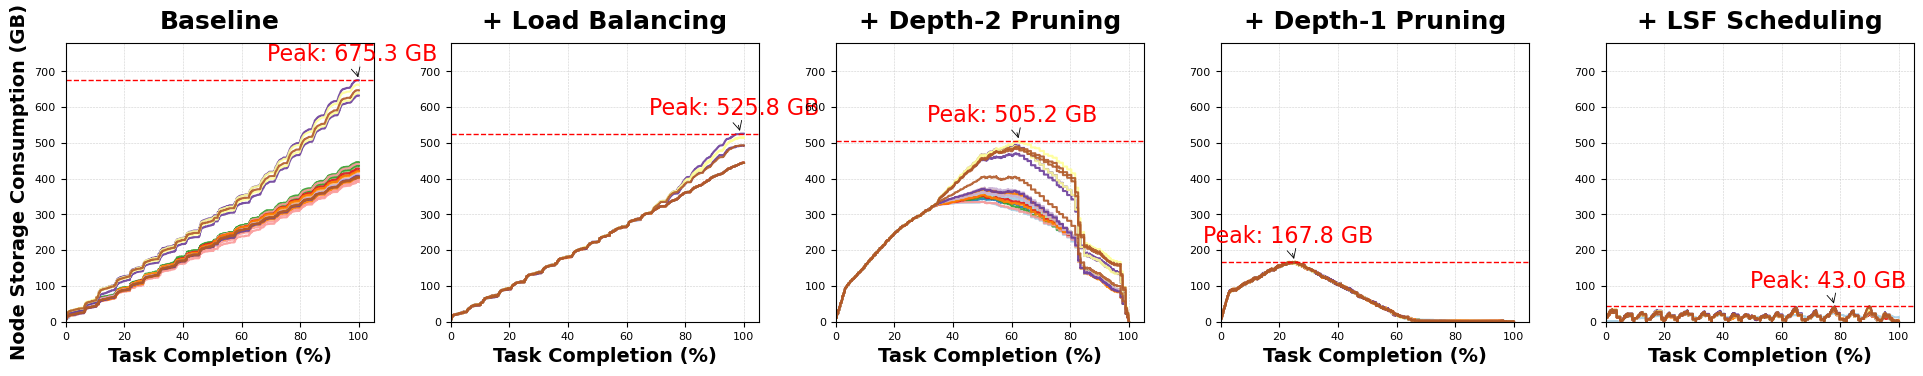

In [34]:
titles = [
    "Baseline", 
    "+ Load Balancing", 
    "+ Depth-2 Pruning", 
    "+ Depth-1 Pruning", 
    "+ SFM Scheduling"
]

plot_all_storage_consumption_subplots_with_peaks(
    filtered_data_list=storage_consumption_filtered_data,
    exclude_workers_list=outlier_workers,
    titles=titles,
    output_path="node_storage_consumption.pdf"
)


/tmp/ipykernel_1228855/3160647065.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


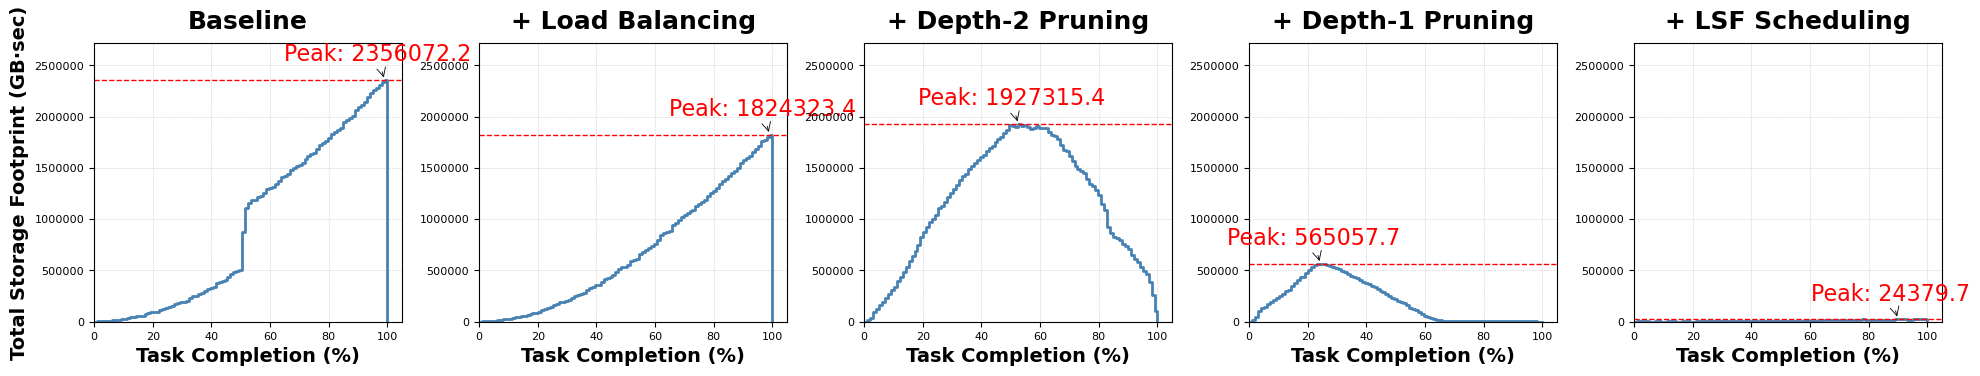

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.gridspec import GridSpec

def plot_all_storage_footprint_subplots(
    data_parsers,
    titles=None,
    output_path="storage_footprint_all.pdf",
    num_points=100
):
    num_logs = len(data_parsers)
    fig_width = 4.2 * num_logs
    fig_height = 4.5

    fig = plt.figure(figsize=(fig_width, fig_height))
    gs = GridSpec(1, num_logs, figure=fig, wspace=0.25, left=0.08, right=0.96, top=0.84, bottom=0.22)

    footprint_series_list = []
    global_yMax = 0

    for parser in data_parsers:
        tasks = [t for t in parser.tasks.values() if t.task_status is not None and t.when_done is not None]
        if not tasks:
            footprint_series_list.append(([], []))
            continue

        tasks.sort(key=lambda t: t.when_done)
        time_points = [t.when_done for t in tasks]
        timestamp_at_percentile = np.percentile(time_points, np.linspace(0, 100, num_points))

        file_infos = []
        for f in parser.files.values():
            if f.size_mb <= 0 or not f.producers:
                continue

            retrieved_times = []
            for t in f.producers:
                if isinstance(t, tuple):
                    t = parser.tasks.get(t)
                if t and t.when_retrieved:
                    retrieved_times.append(t.when_retrieved)
            if not retrieved_times:
                continue
            create_time = min(retrieved_times)

            last_stage_out = None
            for tr in f.transfers:
                if tr.time_stage_out is not None:
                    if last_stage_out is None or tr.time_stage_out > last_stage_out:
                        last_stage_out = tr.time_stage_out
            if last_stage_out is None:
                last_stage_out = parser.manager.time_end

            file_infos.append((create_time, last_stage_out, f.size_mb))

        # 计算 footprint 时间序列
        x_vals = []
        y_vals = []
        for i, t in enumerate(timestamp_at_percentile):
            footprint = 0.0
            for create, out, size in file_infos:
                if create > t or out <= t:
                    continue
                retention = t - create
                footprint += size * retention
            x_vals.append(i * 100 / (num_points - 1))
            y_vals.append(footprint / 1024)  # GB·sec

        footprint_series_list.append((x_vals, y_vals))
        global_yMax = max(global_yMax, max(y_vals, default=0))
    global_yMax *= 1.05

    # 开始绘图
    for i in range(num_logs):
        parser = data_parsers[i]
        title = titles[i] if titles and i < len(titles) else None
        ax = fig.add_subplot(gs[0, i])

        x_min, x_max = 0, 100
        y_min, y_max = 0, global_yMax

        x_label = "Task Completion (%)"
        y_label = "Total Storage Footprint (GB·sec)"

        x, y = footprint_series_list[i]
        if not x:
            continue

        ax.step(x, y, where='post', color='steelblue', linewidth=2)

        peak_idx = np.argmax(y)
        peak_value = y[peak_idx]
        peak_x = x[peak_idx]

        ax.axhline(y=peak_value, color='red', linestyle='--', linewidth=1)
        ax.annotate(f'Peak: {peak_value:.1f}',
                    xy=(peak_x, peak_value),
                    xytext=(-5, 10),
                    textcoords='offset points',
                    arrowprops=dict(facecolor='black', arrowstyle='->', lw=0.6),
                    color='red', fontsize=16, ha='center', va='bottom')

        x_pad = (x_max - x_min) * 0.05
        y_pad = (y_max - y_min) * 0.1
        ax.set_xlim(x_min, x_max + x_pad)
        ax.set_ylim(y_min, y_max + y_pad)

        ax.set_xlabel(x_label, fontsize=14, fontweight='bold')
        if i == 0:
            ax.set_ylabel(y_label, fontsize=14, fontweight='bold')
        else:
            ax.set_yticklabels([])

        ax.tick_params(axis='both', labelsize=8)
        ax.grid(True, linestyle='--', linewidth=0.4, alpha=0.6)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))

        if title:
            ax.set_title(title, fontsize=18, fontweight='bold', pad=10)

    plt.tight_layout()
    plt.show()
    fig.savefig(output_path, bbox_inches='tight', dpi=3000)
    plt.close()


plot_all_storage_footprint_subplots(
    data_parsers=data_parsers,
    titles=[
        "Baseline",
        "+ Load Balancing",
        "+ Depth-2 Pruning",
        "+ Depth-1 Pruning",
        "+ SFM Scheduling"
    ],
    output_path="storage_footprint_all.pdf"
)


In [26]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import numpy as np
import tqdm

def get_worker_transfers(base_url, runtime_template, transfer_type='incoming'):
    try:
        r1 = requests.get(f"{base_url}/api/change-runtime-template", 
                          params={"runtime_template": runtime_template,})
        r1.raise_for_status()
        if not r1.json().get("success", False):
            print(f"[ERROR] Failed to change template to {runtime_template}")
            return None
        r2 = requests.get(f"{base_url}/api/worker-transfers", 
                          params={
                              "type": transfer_type,
                              "x_unit": "completed-tasks"
                              })
        r2.raise_for_status()
        return r2.json()
    except Exception as e:
        print(f"[ERROR] {runtime_template} - {transfer_type} failed: {e}")
        return None
    
def cumulative_to_events(points):
    """Convert a cumulative transfer series back into +1/-1 events"""
    events = []
    prev_value = 0
    for time, cum_value in points:
        delta = cum_value - prev_value
        if delta != 0:
            events.append([time, delta])
        prev_value = cum_value
    return events


def get_combined_transfer_data(base_url, runtime_template):
    incoming = get_worker_transfers(base_url, runtime_template, 'incoming')
    outgoing = get_worker_transfers(base_url, runtime_template, 'outgoing')
    if not incoming or not outgoing:
        return None

    combined = {
        'transfers': {},
        'xMin': min(incoming['xMin'], outgoing['xMin']),
        'xMax': max(incoming['xMax'], outgoing['xMax']),
        'tickFontSize': incoming.get('tickFontSize', 10),
    }

    all_workers = set(incoming['transfers']) | set(outgoing['transfers'])

    yMax = 0

    for worker in all_workers:
        inc_points = incoming['transfers'].get(worker, [])
        out_points = outgoing['transfers'].get(worker, [])

        inc_events = cumulative_to_events(inc_points)
        out_events = cumulative_to_events(out_points)

        df = pd.DataFrame(inc_events + out_events, columns=["time", "event"])
        df = df.groupby("time").sum().sort_index().reset_index()
        df["cumulative"] = df["event"].cumsum()
        df = df.drop_duplicates(subset=["time"], keep="last")
        points = df[["time", "cumulative"]].values.tolist()

        if points:
            combined["transfers"][worker] = points
            yMax = max(yMax, max(p[1] for p in points))

    combined['xUnit'] = incoming['xUnit']
    combined['yMax'] = int(yMax)
    combined['yMin'] = 0
    combined['xTickValues'] = [
        round(combined['xMin'], 2),
        round(combined['xMin'] + (combined['xMax'] - combined['xMin']) * 0.25, 2),
        round(combined['xMin'] + (combined['xMax'] - combined['xMin']) * 0.5, 2),
        round(combined['xMin'] + (combined['xMax'] - combined['xMin']) * 0.75, 2),
        round(combined['xMax'], 2)
    ]
    combined['yTickValues'] = [
        0,
        int(yMax * 0.25),
        int(yMax * 0.5),
        int(yMax * 0.75),
        int(yMax)
    ]
    return combined


base_url = "http://localhost:9122"
runtime_templates = [
    "exp2_dv5_load_balancing_disabled",
    "exp2_dv5_load_balancing_enabled",
    "exp2_dv5_prune_depth2_FIFO",
    "exp2_dv5_prune_depth1_FIFO",
    "exp2_dv5_prune_depth1_storage-footprint-aware"
]
titles = [
    "Baseline",
    "+ Load Balancing",
    "+ Depth-2 Pruning",
    "+ Depth-1 Pruning",
    "+ SFM Scheduling"
]

all_transfer_data = []
for tmpl in tqdm.tqdm(runtime_templates, desc="Fetching transfers"):
    data = get_combined_transfer_data(base_url, tmpl)
    all_transfer_data.append(data)


Fetching transfers:   0%|          | 0/5 [00:00<?, ?it/s]

xunit: completed-tasks


Fetching transfers:  20%|██        | 1/5 [00:16<01:07, 16.76s/it]

xunit: completed-tasks


Fetching transfers:  40%|████      | 2/5 [01:17<02:07, 42.38s/it]

xunit: completed-tasks


Fetching transfers:  60%|██████    | 3/5 [02:12<01:36, 48.44s/it]

xunit: completed-tasks


Fetching transfers:  80%|████████  | 4/5 [04:57<01:34, 94.53s/it]

xunit: completed-tasks


Fetching transfers: 100%|██████████| 5/5 [06:02<00:00, 72.59s/it]


/tmp/ipykernel_1325758/368911303.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('Paired', len(workers))
/tmp/ipykernel_1325758/368911303.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('Paired', len(workers))


/tmp/ipykernel_1325758/368911303.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('Paired', len(workers))
/tmp/ipykernel_1325758/368911303.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('Paired', len(workers))
/tmp/ipykernel_1325758/368911303.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


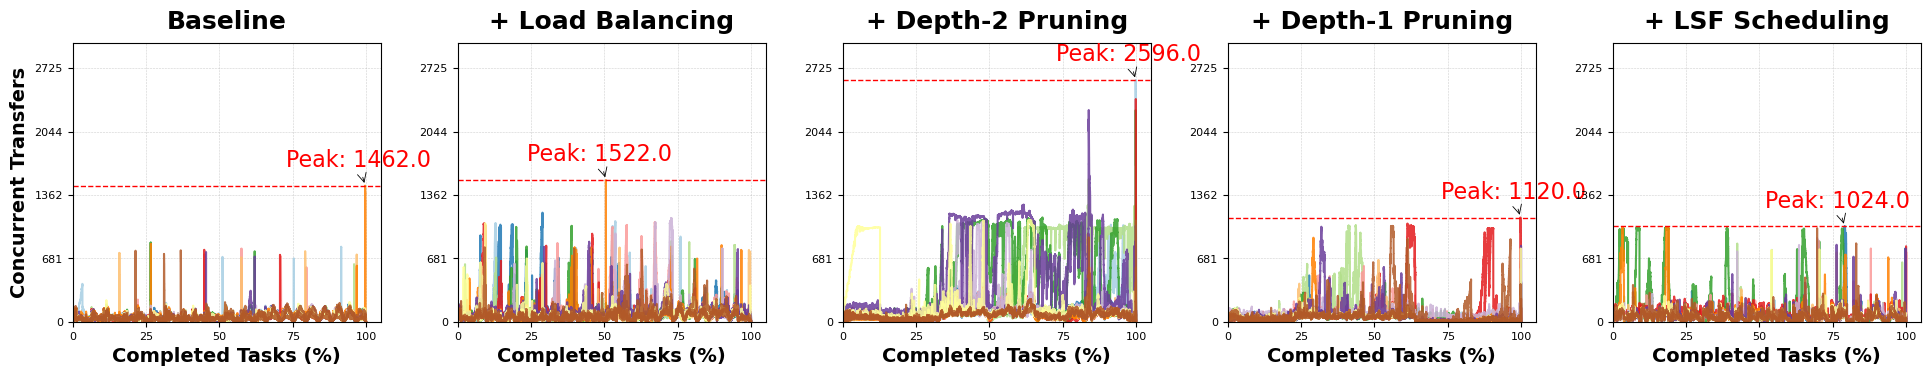

In [38]:
for i in range(len(all_transfer_data)):
    all_transfer_data[i]['xUnit'] = "completed-tasks"

def plot_all_total_transfer_subplots_with_peaks(
    data_list,
    titles=None,
    output_path="total_transfers_all.pdf"
):
    num_logs = len(data_list)
    fig_width = 4.2 * num_logs
    fig_height = 4.5
    fig = plt.figure(figsize=(fig_width, fig_height))
    gs = GridSpec(1, num_logs, figure=fig, wspace=0.25, left=0.08, right=0.96, top=0.84, bottom=0.22)

    y_global_max = max(d['yMax'] for d in data_list) * 1.05
    yTickValues = [
        0,
        int(y_global_max * 0.25),
        int(y_global_max * 0.5),
        int(y_global_max * 0.75),
        int(y_global_max)
    ]

    for i in range(num_logs):
        data = data_list[i]
        title = titles[i] if titles and i < len(titles) else None
        ax = fig.add_subplot(gs[0, i])

        workers = list(data['transfers'].keys())
        color_map = cm.get_cmap('Paired', len(workers))

        peak_value = -1
        peak_time = -1

        for j, worker in enumerate(workers):
            arr = np.array(data['transfers'][worker])
            if arr.shape[1] != 2:
                continue
            t, v = arr[:, 0], arr[:, 1]
            ax.step(t, v, where='post', color=color_map(j), linewidth=1.5, alpha=0.85)

            idx = np.argmax(v)
            if v[idx] > peak_value:
                peak_value = v[idx]
                peak_time = t[idx]

        x_min, x_max = data['xMin'], data['xMax']
        y_min, y_max = 0, y_global_max
        x_pad = (x_max - x_min) * 0.05
        y_pad = y_max * 0.1
        ax.set_xlim(x_min, x_max + x_pad)
        ax.set_ylim(y_min, y_max + y_pad)

        xlabel = "Time (s)" if data.get("xUnit", "time") == "time" else "Completed Tasks (%)"
        ax.set_xlabel(xlabel, fontsize=14, fontweight='bold')

        if i == 0:
            ax.set_ylabel("Concurrent Transfers", fontsize=14, fontweight='bold')
        else:
            ax.set_yticklabels([])

        ax.set_xticks(data['xTickValues'])
        ax.set_yticks(yTickValues)

        ax.tick_params(axis='both', labelsize=8)
        ax.grid(True, linestyle='--', linewidth=0.4, alpha=0.6)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))

        if title:
            ax.set_title(title, fontsize=18, fontweight='bold', pad=10)

        if peak_value > 0:
            ax.axhline(y=peak_value, color='red', linestyle='--', linewidth=1)
            ax.annotate(f'Peak: {peak_value:.1f}',
                        xy=(peak_time, peak_value),
                        xytext=(-5, 10),
                        textcoords='offset points',
                        arrowprops=dict(facecolor='black', arrowstyle='->', lw=0.6),
                        color='red', fontsize=16, ha='center', va='bottom')

    plt.tight_layout()
    # plt.show()
    plt.savefig(output_path, bbox_inches='tight', dpi=1000)
    # plt.close()


plot_all_total_transfer_subplots_with_peaks(
    data_list=all_transfer_data,
    titles=titles,
    output_path="node_concurrent_transfers.pdf"
)
